In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d shayanfazeli/heartbeat

 83% 82.0M/98.8M [00:00<00:00, 140MB/s]
100% 98.8M/98.8M [00:00<00:00, 152MB/s]


In [6]:
!unzip heartbeat.zip

Archive:  heartbeat.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


In [7]:
import numpy as np 
import pandas as pd 
import os, tqdm, re, time, itertools, sys
import seaborn as sns
from sklearn.model_selection import train_test_split
data_train = pd.read_csv('./mitbih_train.csv', header=None)
data_test = pd.read_csv('./mitbih_test.csv', header=None)
abnormal = pd.read_csv('./ptbdb_abnormal.csv', header=None)
normal = pd.read_csv('./ptbdb_normal.csv', header=None)

In [8]:
normal = normal.drop([187], axis=1)
abnormal = abnormal.drop([187], axis=1)

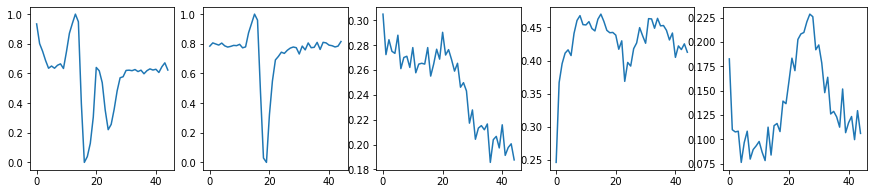

In [9]:
import matplotlib.pyplot as plt
#Abnormal ECG
plt.figure(figsize=(15, 3))
plt.subplot(1, 5, 1)
plt.plot(abnormal.values[0][5:50])
plt.subplot(1, 5, 2)
plt.plot(abnormal.values[10][5:50])
plt.subplot(1, 5, 3)
plt.plot(abnormal.values[20][5:50])
plt.subplot(1, 5, 4)
plt.plot(abnormal.values[40][5:50])
plt.subplot(1, 5, 5)
plt.plot(abnormal.values[44][5:50])

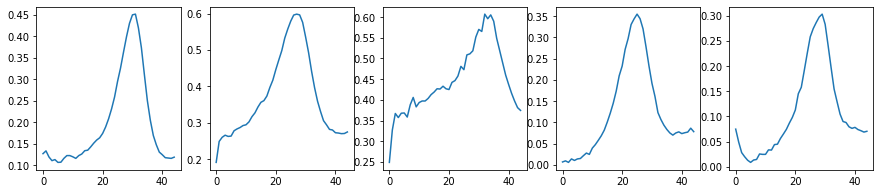

In [10]:
#Normal ECG
plt.figure(figsize=(15, 3))
plt.subplot(1, 5, 1)
plt.plot(normal.values[0][5:50])
plt.subplot(1, 5, 2)
plt.plot(normal.values[10][5:50])
plt.subplot(1, 5, 3)
plt.plot(normal.values[20][5:50])
plt.subplot(1, 5, 4)
plt.plot(normal.values[40][5:50])
plt.subplot(1, 5, 5)
plt.plot(normal.values[77][5:50])

In [11]:
data_1 = data_train[data_train[187] == 1]
data_2 = data_train[data_train[187] == 2]
data_3 = data_train[data_train[187] == 3]
data_4 = data_train[data_train[187] == 4]


In [12]:
y_abnormal = np.ones(abnormal.shape[0])
y_abnormal = pd.DataFrame(y_abnormal)

y_normal = np.zeros(normal.shape[0])
y_normal = pd.DataFrame(y_normal)

X = pd.concat([abnormal, normal], sort=True)
y = pd.concat([y_abnormal, y_normal], sort=True)

In [13]:
print(X.shape)
print(y.shape)

(14552, 187)
(14552, 1)


In [14]:
#data augumentation using resampling because the classes are not distributed equally(biasness)
from sklearn.utils import resample
data_1_resample = resample(data_1, n_samples=20000, 
                           random_state=123, replace=True)
data_2_resample = resample(data_2, n_samples=20000, 
                           random_state=123, replace=True)
data_3_resample = resample(data_3, n_samples=20000, 
                           random_state=123, replace=True)
data_4_resample = resample(data_4, n_samples=20000, 
                           random_state=123, replace=True)
data_0 = data_train[data_train[187] == 0].sample(n=20000, random_state=123)

In [15]:
train_dataset = pd.concat([data_0, data_1_resample, data_2_resample, data_3_resample, 
                          data_4_resample])

In [16]:
target_train = train_dataset[187]
target_test = data_test[187]
target_train.unique()

array([0., 1., 2., 3., 4.])

In [17]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(target_train)
y_test = to_categorical(target_test)

In [18]:
X_train = train_dataset.iloc[:, :-1].values
X_test = data_test.iloc[:, :-1].values

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100000, 187)
(21892, 187)
(100000, 5)
(21892, 5)


In [20]:
#reshaping data to apply cnn
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train.shape, X_test.shape

((100000, 187, 1), (21892, 187, 1))

In [21]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
Conv1D, MaxPooling1D,BatchNormalization,ConvLSTM1D
import tensorflow as tf
from tensorflow.keras.layers import Input, DepthwiseConv1D
from tensorflow.keras.layers import Conv1D, BatchNormalization, LSTM
from tensorflow.keras.layers import ReLU, AvgPool1D, Flatten, Dense
from tensorflow.keras import Model

In [22]:
i_shape = X_train.shape
print(i_shape)

(100000, 187, 1)


In [23]:
image_width = 187
image_height = 1

In [24]:
input = tf.keras.layers.Input((image_width, image_height))
# encoder 
# 1
# kernel initializer provides us with initial weights
c1 = Conv1D(filters=96, input_shape=i_shape, kernel_size=11, strides=4, padding='valid',  activation = 'relu', kernel_initializer = 'he_normal')(input)
d1 = tf.keras.layers.Dropout(0.2)(c1)
m1 = MaxPooling1D(pool_size=2, strides=2, padding='valid')(d1)
b1 = BatchNormalization()(m1)

# 2
c2 = Conv1D(filters=256, kernel_size=11, strides=1, padding='valid', activation = 'relu', kernel_initializer = 'he_normal')(b1)
d2 = tf.keras.layers.Dropout(0.2)(c2)
m2 = MaxPooling1D(pool_size=1, strides=1, padding='valid')(d2)
b2 = BatchNormalization()(m2)

# 3
c3 = Conv1D(filters=384, kernel_size=3, strides=1, padding='valid', activation = 'relu', kernel_initializer = 'he_normal')(b2)
d3 = tf.keras.layers.Dropout(0.2)(c3)
b3 = BatchNormalization()(d3)

# 4
c4 = Conv1D(filters=384, kernel_size=3, strides=2, padding='valid', activation = 'relu', kernel_initializer = 'he_normal')(b3)
d4 = tf.keras.layers.Dropout(0.2)(c4)
b4 = BatchNormalization()(d4)
# 5 
c5 = Conv1D(filters=256, kernel_size=3, strides=2, padding='valid', activation = 'relu', kernel_initializer = 'he_normal')(b4)
d5 = tf.keras.layers.Dropout(0.1)(c5)
m5 = MaxPooling1D(pool_size =1, strides=2, padding='valid')(d5)

In [25]:
print(m5.shape)

(None, 1, 256)


In [74]:
# decoders( UPSAMPLING LAYERS)

# 1
u5 = tf.keras.layers.Conv1DTranspose(384, kernel_size = 4 , strides = 2, padding = 'valid')(m5)
u5 = tf.keras.layers.concatenate([u5, c4])
c6 = tf.keras.layers.Conv1D(384, kernel_size = 3 ,strides = 2, activation = 'relu', kernel_initializer= 'he_normal', padding = 'valid')(u5)
d6 = tf.keras.layers.Dropout(0.2)(c6)

# 2
u4 = tf.keras.layers.Conv1DTranspose(384, kernel_size = 10 , strides = 2, padding = 'valid')(c6)
u4 = tf.keras.layers.concatenate([u4, c3])
c7 = tf.keras.layers.Conv1D(384, kernel_size = 3 ,strides = 2, activation = 'relu', kernel_initializer= 'he_normal', padding = 'valid')(u4)
d7 = tf.keras.layers.Dropout(0.2)(c7)

# 3
u3 = tf.keras.layers.Conv1DTranspose(256, kernel_size = 2 , strides = 3, padding = 'valid')(c7)
u3 = tf.keras.layers.concatenate([u3, c2])
c8 = tf.keras.layers.Conv1D(256, kernel_size = 3 ,strides = 2, activation = 'relu', kernel_initializer= 'he_normal', padding = 'valid')(u3)
d8 = tf.keras.layers.Dropout(0.2)(c8)

# 3
u2 = tf.keras.layers.Conv1DTranspose(96, kernel_size = 17 , strides = 7, padding = 'valid')(c8)
u2 = tf.keras.layers.concatenate([u2, c1])
c9 = tf.keras.layers.Conv1D(96, kernel_size = 3 ,strides = 2, activation = 'relu', kernel_initializer= 'he_normal', padding = 'valid')(u2)
m1 = tf.keras.layers.MaxPooling1D(pool_size = 1, strides = 2, padding = 'valid')(c9)
d9 = tf.keras.layers.Dropout(0.2)(m1)

# c10 = Conv1D(filters=384, kernel_size=3, strides=1,activation = 'relu', padding='valid')(d9)
# m10 = MaxPooling1D(pool_size=1, strides=2, padding='valid')(c10)
# b10 = BatchNormalization()(m10)
# c11 = Conv1D(filters=256, activation= 'relu', kernel_size=2, padding='valid')(b10)
# m11 = MaxPooling1D(pool_size=1, strides=1, padding='valid')(c11)

# l1 = LSTM()(m11)

# i_shape = d9.shape
# our previous model
C1 = Conv1D(filters=96, kernel_size=3,strides=4, activation = 'relu', padding='same')(d9)
M1 = MaxPooling1D(pool_size=1, strides=2, padding='same')(C1)
B1 = BatchNormalization()(M1)
D1 = Dropout(0.2)(B1)
C2 = Conv1D(filters=256, activation= 'relu', kernel_size=2, strides=1, padding='same')(D1)
M2 = MaxPooling1D(pool_size=1, strides=1, padding='same')(C2)
B2 = BatchNormalization()(M2)
D2 = Dropout(0.2)(B2)
C3 = Conv1D(filters=384, kernel_size=1,activation = 'relu', padding='same')(B2)
B3 = BatchNormalization()(C3)
D3 = Dropout(0.2)(B3)
C4 = Conv1D(filters=384, kernel_size=3, strides=1,activation = 'relu', padding='same')(D3)
B4 = BatchNormalization()(C4)
D4 = Dropout(0.2)(B4)
C5 = Conv1D(filters=256, kernel_size=3, strides=2,activation = 'relu', padding='same')(D4)
M5 = MaxPooling1D(pool_size=1, strides=2, padding='same')(C5)
B4 = BatchNormalization()(M5)
D5 = Dropout(0.2)(B4)
C6 = Conv1D(filters=256, kernel_size=3, strides=2,activation = 'relu', padding='same')(D5)
M6 = MaxPooling1D(pool_size=1, strides=2, padding='same')(C6)
L1 = LSTM(384, return_sequences = True)(M6)
L2 = LSTM(256, return_sequences = True)(L1)
L3 = LSTM(128)(L2)
B6 = BatchNormalization()(L1)
# Passing it to a dense layer
f1 = Flatten()(l1)
# 1st Dense Layer
D1 = Dense(256)(f1)
A1 = Activation('relu')(D1)
# Add Dropout to prevent overfitting
D_1 = Dropout(0.5)(A1)
# Batch Normalisation
B_1 = BatchNormalization()(D_1)

# 2nd Dense Layer
D2 = Dense(256)(B_1)
A2 = Activation('relu')(D2)
# Add Dropout
D_2 = Dropout(0.5)(A2)
# Batch Normalisation
B_2 = BatchNormalization()(D_2)

# 3rd Dense Layer
D3 = Dense(128)(B_2)
A3 = Activation('relu')(D3)
# Add Dropout
D_3 = Dropout(0.5)(A3)
# Batch Normalisation
B_3 = BatchNormalization()(D_3)

# Output Layer
output = Dense(5, activation = 'softmax')(B_3)
# model
model = tf.keras.Model(inputs = [input], outputs = [output])


for layer in model.layers:
    print(layer.output_shape)

model.summary()

[(None, 187, 1)]
(None, 45, 96)
(None, 45, 96)
(None, 22, 96)
(None, 22, 96)
(None, 12, 256)
(None, 12, 256)
(None, 12, 256)
(None, 12, 256)
(None, 10, 384)
(None, 10, 384)
(None, 10, 384)
(None, 4, 384)
(None, 4, 384)
(None, 4, 384)
(None, 1, 256)
(None, 1, 256)
(None, 1, 256)
(None, 4, 384)
(None, 4, 768)
(None, 1, 384)
(None, 10, 384)
(None, 10, 768)
(None, 4, 384)
(None, 12, 256)
(None, 12, 512)
(None, 5, 256)
(None, 45, 96)
(None, 45, 192)
(None, 22, 96)
(None, 11, 96)
(None, 11, 96)
(None, 9, 384)
(None, 5, 384)
(None, 5, 384)
(None, 4, 256)
(None, 4, 256)
(None, 128)
(None, 128)
(None, 256)
(None, 256)
(None, 256)
(None, 256)
(None, 256)
(None, 256)
(None, 256)
(None, 256)
(None, 128)
(None, 128)
(None, 128)
(None, 128)
(None, 5)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None

In [76]:
# i_shape = d9.shape
# input = d9
# # our previous model
# C1 = Conv1D(filters=96, input_shape = i_shape, kernel_size=11,strides=4, activation = 'relu', padding='valid')(input)
# M1 = MaxPooling1D(pool_size=1, strides=2, padding='valid')(C1)
# B1 = BatchNormalization()(M1)
# C2 = Conv1D(filters=256, activation= 'relu', kernel_size=11, padding='valid')(B1)
# M2 = MaxPooling1D(pool_size=1, strides=1, padding='valid')(C2)
# B2 = BatchNormalization()(M2)
# C3 = Conv1D(filters=384, kernel_size=3, strides=1,activation = 'relu', padding='valid')(B2)
# B3 = BatchNormalization()(C3)
# C4 = Conv1D(filters=384, kernel_size=3, strides=1,activation = 'relu', padding='valid')(B3)
# B4 = BatchNormalization()(C4)

# C5 = Conv1D(filters=384, kernel_size=3, strides=1,activation = 'relu', padding='valid')(B4)
# M5 = MaxPooling1D(pool_size=1, strides=2, padding='valid')(C5)
# L1 = LSTM(256)(M5)
# B5 = BatchNormalization()(L1)
# # Passing it to a dense layer
# f1 = Flatten()(B5)
# # 1st Dense Layer
# D1 = Dense(256, input_shape=(1800,))(f1)
# A1 = Activation('relu')(D1)
# # Add Dropout to prevent overfitting
# D_1 = Dropout(0.5)(A1)
# # Batch Normalisation
# B_1 = BatchNormalization()(D_1)

# # 2nd Dense Layer
# D2 = Dense(256)(B_1)
# A2 = Activation('relu')(D2)
# # Add Dropout
# D_2 = Dropout(0.5)(A2)
# # Batch Normalisation
# B_2 = BatchNormalization()(D_2)

# # 3rd Dense Layer
# D3 = Dense(128)(B_2)
# A3 = Activation('relu')(D3)
# # Add Dropout
# D_3 = Dropout(0.5)(A3)
# # Batch Normalisation
# B_3 = BatchNormalization()(D_3)

# # Output Layer
# output = Dense(5, activation = 'softmax')(B_3)
# # model
# model = tf.keras.Model(inputs = [input], outputs = [output])


# for layer in model.layers:
#     print(layer.output_shape)

# model.summary()

In [77]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [78]:
print(y_train)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [79]:
print(y_test)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [97]:
history = model.fit(X_train, y_train, epochs=50, batch_size=256, 
          validation_data=(X_test, y_test))

Epoch 1/50
391/391 [==============================] - 17s 44ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.1882 - val_accuracy: 0.9770
Epoch 2/50
391/391 [==============================] - 18s 45ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.1762 - val_accuracy: 0.9771
Epoch 3/50
391/391 [==============================] - 17s 44ms/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 0.1767 - val_accuracy: 0.9753
Epoch 4/50
391/391 [==============================] - 17s 44ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.1954 - val_accuracy: 0.9765
Epoch 5/50
391/391 [==============================] - 17s 44ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.2051 - val_accuracy: 0.9741
Epoch 6/50
391/391 [==============================] - 17s 44ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.1876 - val_accuracy: 0.9745
Epoch 7/50
391/391 [==============================] - 17s 44ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.2125 - val_accuracy:

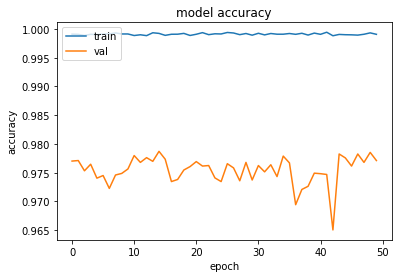

In [98]:
#  plotting accuracy of the model
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

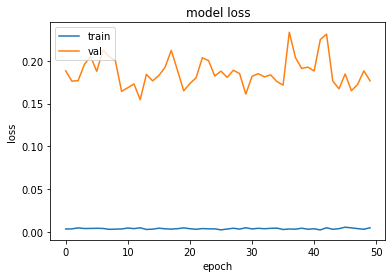

In [99]:
# plottingloss of the model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [100]:
! pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
y_pred = model.predict(X_test)

685/685 [==============================] - 4s 7ms/step


In [102]:
from sklearn.metrics import confusion_matrix
y_pred_1 = np.argmax(y_pred, axis=1)
y_test_1 = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_1, y_pred_1)

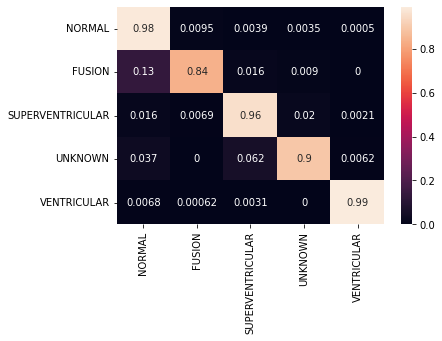

In [103]:
from sklearn.preprocessing import normalize
normed_confusion_matrix = normalize(cm, axis = 1, norm = 'l1')
cm_df = pd.DataFrame(normed_confusion_matrix,
                     index = ['NORMAL','FUSION','SUPERVENTRICULAR', 'UNKNOWN', 'VENTRICULAR'], 
                     columns = ['NORMAL','FUSION','SUPERVENTRICULAR', 'UNKNOWN', 'VENTRICULAR'])
sns.heatmap(cm_df, annot=True)

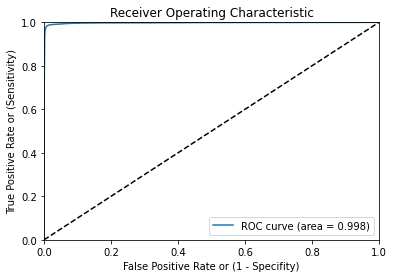

In [104]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred2 = []
y_test2 = []
y_pred2 = np.concatenate(y_pred, axis=0 )
y_true2 = np.concatenate(y_test, axis=0 )

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_true2, y_pred2)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")